Iñigo Martin Melero

## Participante 15

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_15_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


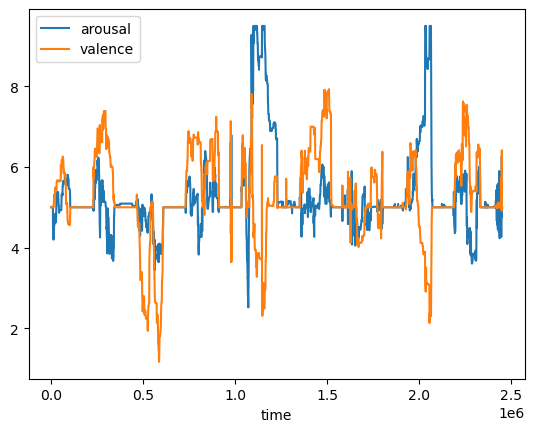

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_15_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.846  35.286  38.452  31.995  26.809     6.631     7.863   
1              1  0.859  35.451  38.464  31.976  26.816     6.590     7.863   
2              2  0.872  35.615  38.476  31.956  26.823     6.549     7.863   
3              3  0.876  35.770  38.500  31.995  26.827     6.672     7.945   
4              4  0.862  35.780  38.385  31.966  26.823     6.549     7.986   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.767  35.751  31.221  30.533  23.829    16.939     6.302   
2451580  2451580  0.761  35.887  31.139  30.524  23.815    16.980     6.302   
2451581  2451581  0.761  36.071  31.182  30.543  23.833    17.185     6.467   
2451582  2451582  0.751  36.138  31.233  30.543  23.829    17.104     6.426   
2451583  2451583  0.774  35.606  31.229  30.562  23.829    17.227     6.508   

         emg_trap  video  
0          13.859     10

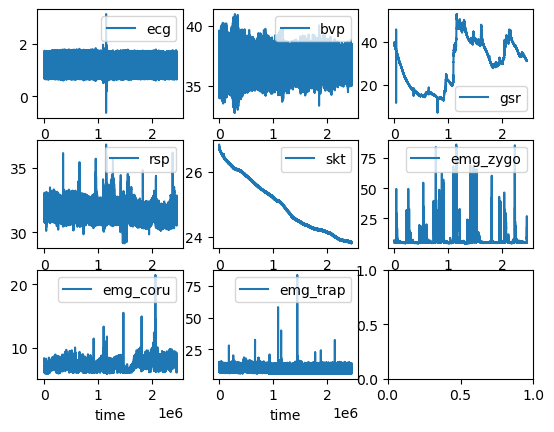

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

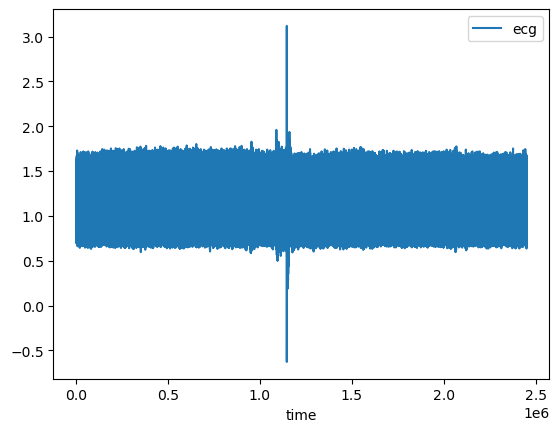

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

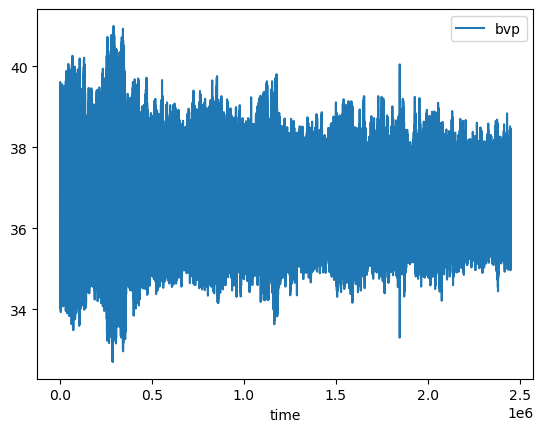

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

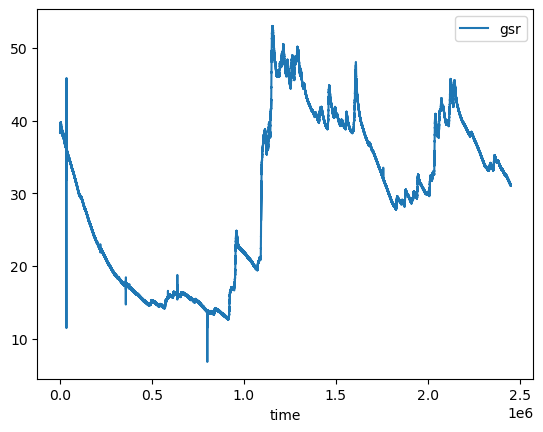

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

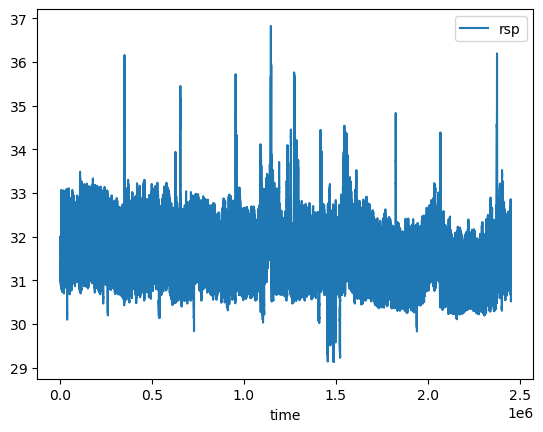

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

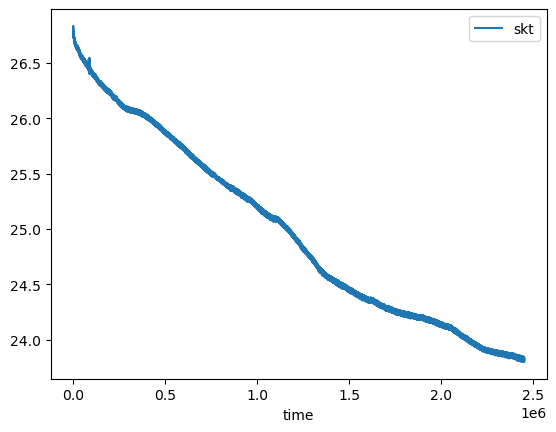

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

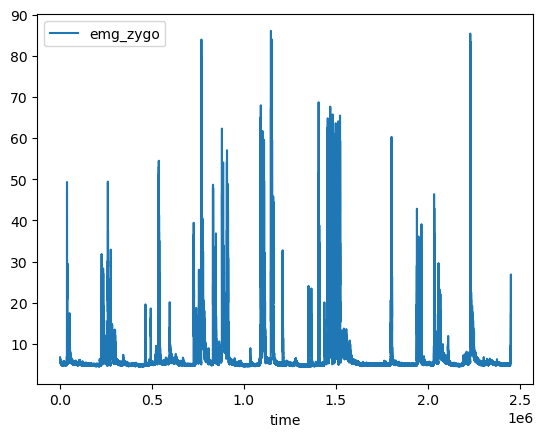

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

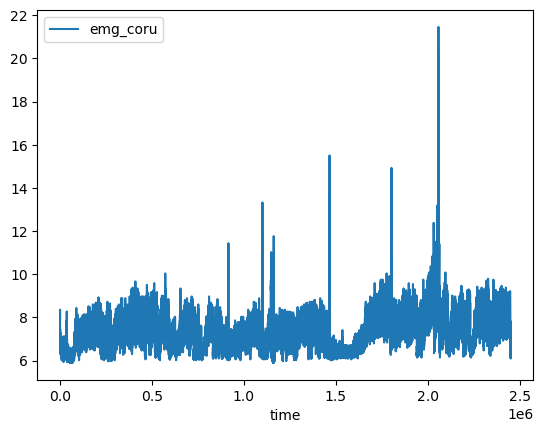

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

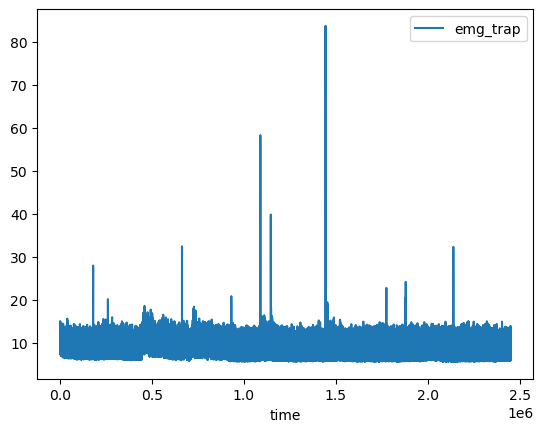

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

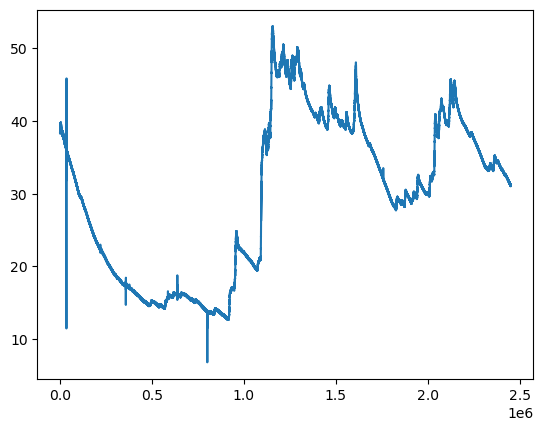

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

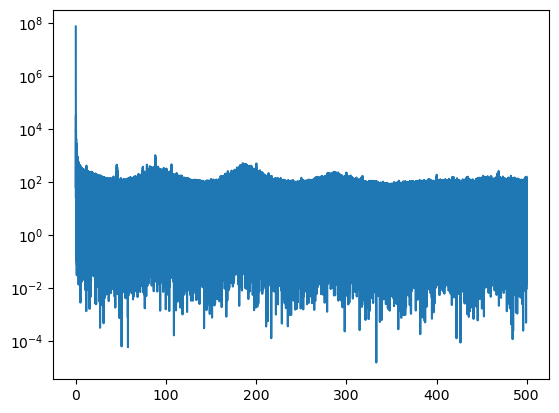

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

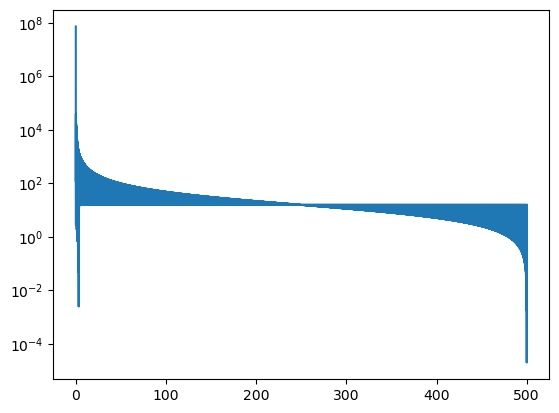

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

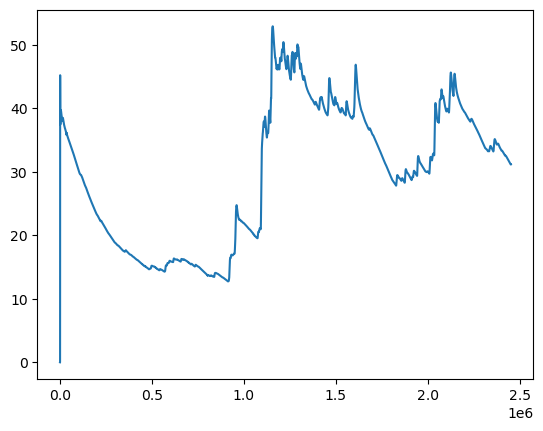

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  31.187
2451580  31.187
2451581  31.187
2451582  31.187
2451583  31.187

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

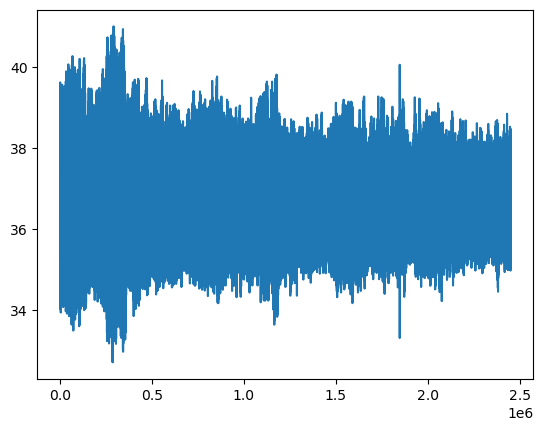

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

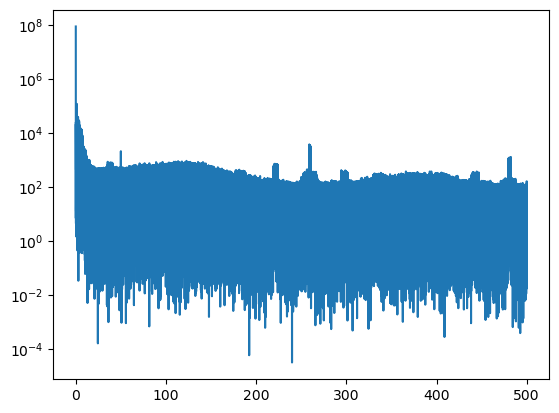

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

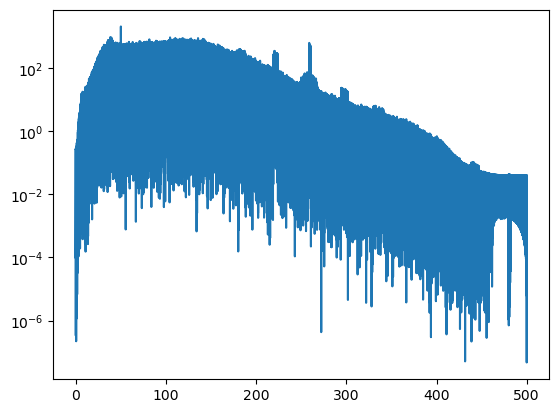

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

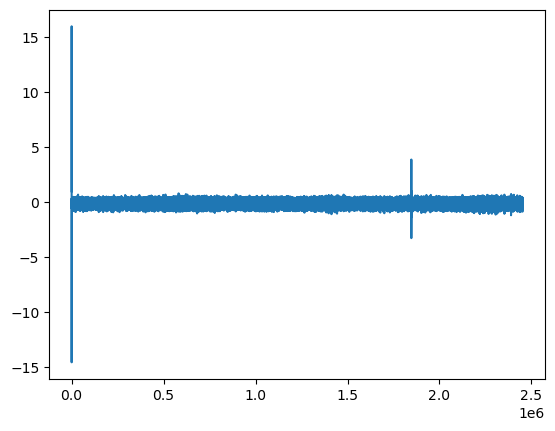

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        37.980
1        42.474
2        49.899
3        53.002
4        46.059
...         ...
2451579  36.973
2451580  37.081
2451581  37.115
2451582  37.094
2451583  37.081

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

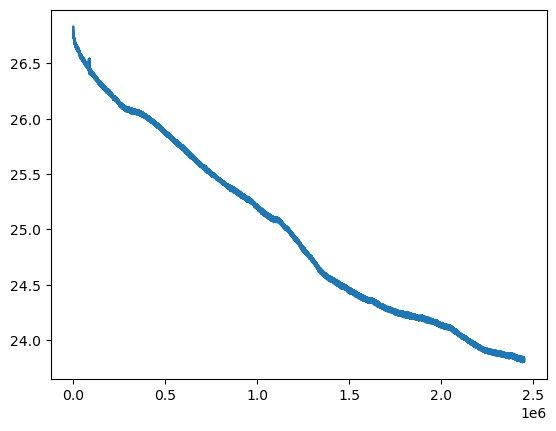

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

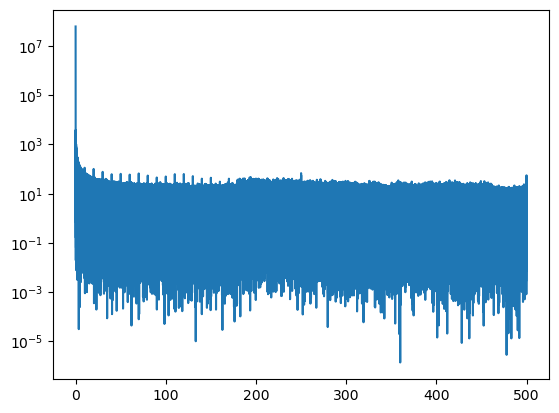

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

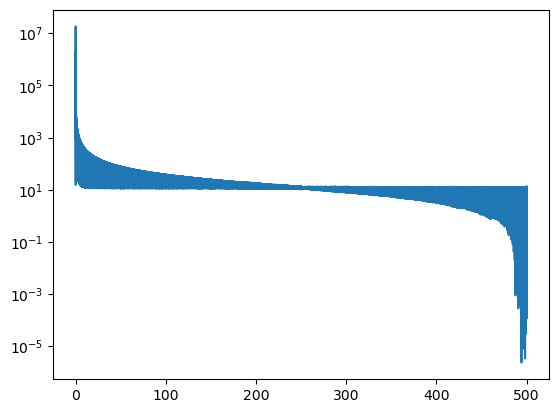

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

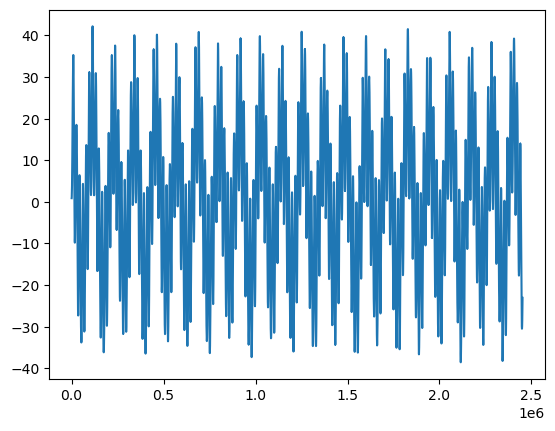

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.859
1        40.859
2        40.860
3        40.860
4        40.860
...         ...
2451579  16.914
2451580  16.918
2451581  16.923
2451582  16.927
2451583  16.931

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.846  31.995     6.631     7.863    13.859     10
1              1  0.859  31.976     6.590     7.863    13.900     10
2              2  0.872  31.956     6.549     7.863    13.941     10
3              3  0.876  31.995     6.672     7.945    14.064     10
4              4  0.862  31.966     6.549     7.986    14.023     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.767  30.533    16.939     6.302     7.165     12
2451580  2451580  0.761  30.524    16.980     6.302     6.960     12
2451581  2451581  0.761  30.543    17.185     6.467     7.206     12
2451582  2451582  0.751  30.543    17.104     6.426     7.083     12
2451583  2451583  0.774  30.562    17.227     6.508     7.247     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.846  31.995     6.631     7.863    13.859     10  37.980   
1              1  0.859  31.976     6.590     7.863    13.900     10  42.474   
2              2  0.872  31.956     6.549     7.863    13.941     10  49.899   
3              3  0.876  31.995     6.672     7.945    14.064     10  53.002   
4              4  0.862  31.966     6.549     7.986    14.023     10  46.059   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.767  30.533    16.939     6.302     7.165     12  36.973   
2451580  2451580  0.761  30.524    16.980     6.302     6.960     12  37.081   
2451581  2451581  0.761  30.543    17.185     6.467     7.206     12  37.115   
2451582  2451582  0.751  30.543    17.104     6.426     7.083     12  37.094   
2451583  2451583  0.774  30.562    17.227     6.508     7.247     12  37.081   

            gsr     skt  
0         0.000  40.859  
1         0.000  40.859  
2         0.000  40.860  
3         0.000  40.860  
4         0.000  40.860  
...         ...     ...  
2451579  31.187  16.914  
2451580  31.187  16.918  
2451581  31.187  16.923  
2451582  31.187  16.927  
2451583  31.187  16.931  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.427581  0.610047  0.235873  0.784332  0.259129  0.004526   
221502    221502  0.424913  0.628690  0.235873  0.784242  0.257830  0.004526   
221503    221503  0.426780  0.620404  0.235873  0.784177  0.257830  0.005532   
221504    221504  0.428381  0.609011  0.235898  0.784099  0.259129  0.006048   
221505    221505  0.433716  0.591403  0.235898  0.784021  0.260299  0.007556   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.425980  0.577939  0.510041  0.349537  0.186095  0.009568   
2331580  2331580  0.417178  0.557742  0.510041  0.349614  0.184925  0.009065   
2331581  2331581  0.411043  0.558778  0.510041  0.349705  0.184925  0.008562   
2331582  2331582  0.409176  0.554117  0.510041  0.349783  0.182326  0.008059   
2331583  2331583  0.412643  0.521491  0.510041  0.349874  0.186095  0.009568   

         emg_coru  emg_trap  video  
221501   0.100231  0.014205      3  
221502   0.100231  0.013680      3  
221503   0.102930  0.014730      3  
221504   0.097597  0.015268      3  
221505   0.102930  0.015781      3  
...           ...       ...    ...  
2331579  0.097597  0.031049      6  
2331580  0.097597  0.037876      6  
2331581  0.089694  0.042090      6  
2331582  0.092328  0.048930      6  
2331583  0.100231  0.054707      6  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.427581  0.610047  0.235873  0.259129  0.784332  0.004526   
221502    221502  0.424913  0.628690  0.235873  0.257830  0.784242  0.004526   
221503    221503  0.426780  0.620404  0.235873  0.257830  0.784177  0.005532   
221504    221504  0.428381  0.609011  0.235898  0.259129  0.784099  0.006048   
221505    221505  0.433716  0.591403  0.235898  0.260299  0.784021  0.007556   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.425980  0.577939  0.510041  0.186095  0.349537  0.009568   
2331580  2331580  0.417178  0.557742  0.510041  0.184925  0.349614  0.009065   
2331581  2331581  0.411043  0.558778  0.510041  0.184925  0.349705  0.008562   
2331582  2331582  0.409176  0.554117  0.510041  0.182326  0.349783  0.008059   
2331583  2331583  0.412643  0.521491  0.510041  0.186095  0.349874  0.009568   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.442518  0.610564  0.235898  0.257830  0.782881  0.004024  0.084426   
221540   0.455588  0.613154  0.235948  0.254061  0.781352  0.005029  0.068620   
221560   0.457455  0.590886  0.235973  0.250292  0.779822  0.004526  0.081791   
221580   0.437183  0.585707  0.235998  0.252762  0.778293  0.005532  0.081791   
221600   0.405708  0.582600  0.236047  0.250292  0.776764  0.005029  0.076523   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.360096  0.595028  0.510066  0.186095  0.343031  0.006538  0.108134   
2331520  0.360896  0.599171  0.510066  0.192463  0.344677  0.010574  0.113467   
2331540  0.352361  0.608493  0.510066  0.187394  0.346336  0.010071  0.094963   
2331560  0.575620  0.706888  0.510041  0.184925  0.347982  0.008562  0.089694   
2331580  0.417178  0.557742  0.510041  0.184925  0.349614  0.009065  0.097597   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.442518  0.610564  0.235898  0.257830  0.782881  0.004024  0.084426   
1      0.455588  0.613154  0.235948  0.254061  0.781352  0.005029  0.068620   
2      0.457455  0.590886  0.235973  0.250292  0.779822  0.004526  0.081791   
3      0.437183  0.585707  0.235998  0.252762  0.778293  0.005532  0.081791   
4      0.405708  0.582600  0.236047  0.250292  0.776764  0.005029  0.076523   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.360096  0.595028  0.510066  0.186095  0.343031  0.006538  0.108134   
63500  0.360896  0.599171  0.510066  0.192463  0.344677  0.010574  0.113467   
63501  0.352361  0.608493  0.510066  0.187394  0.346336  0.010071  0.094963   
63502  0.575620  0.706888  0.510041  0.184925  0.347982  0.008562  0.089694   
63503  0.417178  0.557742  0.510041  0.184925  0.349614  0.009065  0.097597   

       emg_trap  valence  arousal  
0      0.015268    5.000    5.000  
1      0.013155    5.000    5.000  
2      0.011579    5.000    5.000  
3      0.012104    5.000    5.000  
4      0.014730    5.000    5.000  
...         ...      ...      ...  
63499  0.006315    6.226    5.733  
63500  0.008415    6.225    5.734  
63501  0.006315    6.224    5.734  
63502  0.007365    6.223    5.734  
63503  0.037876    6.222    5.734  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.442518  0.610564  0.235898  0.257830  0.782881  0.004024  0.084426   
1      0.455588  0.613154  0.235948  0.254061  0.781352  0.005029  0.068620   
2      0.457455  0.590886  0.235973  0.250292  0.779822  0.004526  0.081791   
3      0.437183  0.585707  0.235998  0.252762  0.778293  0.005532  0.081791   
4      0.405708  0.582600  0.236047  0.250292  0.776764  0.005029  0.076523   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.392638  0.550492  0.510091  0.192463  0.336409  0.006048  0.197893   
63496  0.389971  0.709477  0.510091  0.187394  0.338068  0.006538  0.176818   
63497  0.389971  0.572760  0.510091  0.193632  0.339727  0.006048  0.174120   
63498  0.375033  0.604350  0.510066  0.189864  0.341372  0.007053  0.147777   
63499  0.360096  0.595028  0.510066  0.186095  0.343031  0.006538  0.108134   

       emg_trap  valence  arousal  
0      0.015268    5.000    5.000  
1      0.013155    5.000    5.000  
2      0.011579    5.000    5.000  
3      0.012104    5.000    5.000  
4      0.014730    5.000    5.000  
...         ...      ...      ...  
63495  0.008415    6.241    5.725  
63496  0.007365    6.236    5.728  
63497  0.007903    6.231    5.730  
63498  0.006840    6.228    5.732  
63499  0.006315    6.226    5.733  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.442518  0.610564  0.235898  0.257830  0.782881  0.004024  0.084426   
 1   0.455588  0.613154  0.235948  0.254061  0.781352  0.005029  0.068620   
 2   0.457455  0.590886  0.235973  0.250292  0.779822  0.004526  0.081791   
 3   0.437183  0.585707  0.235998  0.252762  0.778293  0.005532  0.081791   
 4   0.405708  0.582600  0.236047  0.250292  0.776764  0.005029  0.076523   
 5   0.391571  0.636976  0.236072  0.256530  0.775235  0.005532  0.079157   
 6   0.378501  0.631279  0.236097  0.246524  0.773693  0.005029  0.089694   
 7   0.383035  0.576385  0.236147  0.244055  0.772151  0.004526  0.094963   
 8   0.377701  0.605904  0.236172  0.238986  0.770608  0.004024  0.094963   
 9   0.383836  0.630761  0.236197  0.244055  0.769066  0.007556  0.116101   
 10  0.381969  0.623511  0.236222  0.241455  0.767524  0.005532  0.102930   
 11  0.383035  0.600207  0.236247  0.240286  0.765969  0.006048  0.094963   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.442518  0.610564  0.235898  0.257830  0.782881  0.004024  0.084426   
1     0.375033  0.592957  0.236471  0.225081  0.744185  0.004024  0.102930   
2     0.390771  0.629726  0.236670  0.215075  0.705281  0.007556  0.073888   
3     0.405708  0.596582  0.236795  0.388694  0.667453  0.004526  0.089694   
4     0.376901  0.561885  0.236571  0.498116  0.631828  0.006048  0.105500   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.371566  0.611600  0.510589  0.187394  0.159425  0.007556  0.147777   
2536  0.376901  0.613672  0.510788  0.337102  0.189399  0.006538  0.100231   
2537  0.400373  0.614707  0.510838  0.400000  0.224117  0.006538  0.129273   
2538  0.381969  0.513206  0.510664  0.269136  0.262515  0.003521  0.134541   
2539  0.371566  0.577939  0.510390  0.211306  0.303220  0.006048  0.134541   

             8         9        10  ...       193       194       195  \
0     0.015268  0.455588  0.613154  ...  0.379301  0.601761  0.236446   
1     0.012630  0.381969  0.657172  ...  0.414511  0.564992  0.236670   
2     0.015268  0.381168  0.573796  ...  0.402241  0.589850  0.236795   
3     0.016318  0.384636  0.586225  ...  0.378501  0.624029  0.236571   
4     0.024721  0.381168  0.583635  ...  0.365431  0.631797  0.236496   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.051030  0.376901  0.626100  ...  0.375834  0.595546  0.510788   
2536  0.011054  0.376901  0.560331  ...  0.392638  0.589850  0.510863   
2537  0.008941  0.414511  0.577939  ...  0.368898  0.619886  0.510689   
2538  0.008415  0.400373  0.598654  ...  0.377701  0.627654  0.510415   
2539  0.010004  0.369699  0.595546  ...  0.360096  0.595028  0.510066   

           196       197       198       199       200  valence  arousal  
0     0.226381  0.745753  0.004024  0.134541  0.014730  5.00000   5.0000  
1     0.216374  0.706823  0.007556  0.076523  0.014205  5.00000   5.0000  
2     0.384925  0.668930  0.004526  0.116101  0.017369  5.00000   5.0000  
3     0.495517  0.633202  0.003521  0.084426  0.024196  5.00000   5.0000  
4     0.413775  0.600557  0.011077  0.068620  0.071550  5.00000   5.0000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.330734  0.188090  0.006048  0.089694  0.011579  6.46500   5.8040  
2536  0.406238  0.222666  0.005532  0.126638  0.013155  6.46500   5.8040  
2537  0.274204  0.260921  0.005029  0.145078  0.008941  6.46504   5.7592  
2538  0.210006  0.301575  0.004526  0.147777  0.011579  6.39212   5.6720  
2539  0.186095  0.343031  0.006538  0.108134  0.006315  6.26688   5.6982  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.442518  0.610564  0.235898  0.257830  0.782881  0.004024  0.084426   
1     0.375033  0.592957  0.236471  0.225081  0.744185  0.004024  0.102930   
2     0.390771  0.629726  0.236670  0.215075  0.705281  0.007556  0.073888   
3     0.405708  0.596582  0.236795  0.388694  0.667453  0.004526  0.089694   
4     0.376901  0.561885  0.236571  0.498116  0.631828  0.006048  0.105500   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.371566  0.611600  0.510589  0.187394  0.159425  0.007556  0.147777   
2536  0.376901  0.613672  0.510788  0.337102  0.189399  0.006538  0.100231   
2537  0.400373  0.614707  0.510838  0.400000  0.224117  0.006538  0.129273   
2538  0.381969  0.513206  0.510664  0.269136  0.262515  0.003521  0.134541   
2539  0.371566  0.577939  0.510390  0.211306  0.303220  0.006048  0.134541   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub15.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.442518  0.610564  0.235898  0.257830  0.782881  0.004024  0.084426   
1     0.375033  0.592957  0.236471  0.225081  0.744185  0.004024  0.102930   
2     0.390771  0.629726  0.236670  0.215075  0.705281  0.007556  0.073888   
3     0.405708  0.596582  0.236795  0.388694  0.667453  0.004526  0.089694   
4     0.376901  0.561885  0.236571  0.498116  0.631828  0.006048  0.105500   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.371566  0.611600  0.510589  0.187394  0.159425  0.007556  0.147777   
2536  0.376901  0.613672  0.510788  0.337102  0.189399  0.006538  0.100231   
2537  0.400373  0.614707  0.510838  0.400000  0.224117  0.006538  0.129273   
2538  0.381969  0.513206  0.510664  0.269136  0.262515  0.003521  0.134541   
2539  0.371566  0.577939  0.510390  0.211306  0.303220  0.006048  0.134541   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub15.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.442518  0.610564  0.235898  0.257830  0.782881  0.004024  0.084426   
1     0.375033  0.592957  0.236471  0.225081  0.744185  0.004024  0.102930   
2     0.390771  0.629726  0.236670  0.215075  0.705281  0.007556  0.073888   
3     0.405708  0.596582  0.236795  0.388694  0.667453  0.004526  0.089694   
4     0.376901  0.561885  0.236571  0.498116  0.631828  0.006048  0.105500   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.371566  0.611600  0.510589  0.187394  0.159425  0.007556  0.147777   
2536  0.376901  0.613672  0.510788  0.337102  0.189399  0.006538  0.100231   
2537  0.400373  0.614707  0.510838  0.400000  0.224117  0.006538  0.129273   
2538  0.381969  0.513206  0.510664  0.269136  0.262515  0.003521  0.134541   
2539  0.371566  0.577939  0.510390  0.211306  0.303220  0.006048  0.134541   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub15.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.442518  0.610564  0.235898  0.257830  0.782881  0.004024  0.084426   
1     0.375033  0.592957  0.236471  0.225081  0.744185  0.004024  0.102930   
2     0.390771  0.629726  0.236670  0.215075  0.705281  0.007556  0.073888   
3     0.405708  0.596582  0.236795  0.388694  0.667453  0.004526  0.089694   
4     0.376901  0.561885  0.236571  0.498116  0.631828  0.006048  0.105500   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.371566  0.611600  0.510589  0.187394  0.159425  0.007556  0.147777   
2536  0.376901  0.613672  0.510788  0.337102  0.189399  0.006538  0.100231   
2537  0.400373  0.614707  0.510838  0.400000  0.224117  0.006538  0.129273   
2538  0.381969  0.513206  0.510664  0.269136  0.262515  0.003521  0.134541   
2539  0.371566  0.577939  0.510390  0.211306  0.303220  0.006048  0.134541   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub15.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.442518  0.610564  0.235898  0.257830  0.782881  0.004024  0.084426   
1     0.375033  0.592957  0.236471  0.225081  0.744185  0.004024  0.102930   
2     0.390771  0.629726  0.236670  0.215075  0.705281  0.007556  0.073888   
3     0.405708  0.596582  0.236795  0.388694  0.667453  0.004526  0.089694   
4     0.376901  0.561885  0.236571  0.498116  0.631828  0.006048  0.105500   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.371566  0.611600  0.510589  0.187394  0.159425  0.007556  0.147777   
2536  0.376901  0.613672  0.510788  0.337102  0.189399  0.006538  0.100231   
2537  0.400373  0.614707  0.510838  0.400000  0.224117  0.006538  0.129273   
2538  0.381969  0.513206  0.510664  0.269136  0.262515  0.003521  0.134541   
2539  0.371566  0.577939  0.510390  0.211306  0.303220  0.006048  0.134541   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub15.csv', index=False)